In [105]:
import pandas as pd
pd.set_option('float_format', '{:.5f}'.format)

import numpy as np
np.set_printoptions(formatter={float: lambda x: '{:.5f}'.format(x)})

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

In [2]:
def get_decomposition(in_df: pd.DataFrame, plot=True, model='additive'):
    
    if len(in_df.columns.values) > 1:
        print("There is more than one column in DataFrame, using first one.")

    work_col = in_df.columns.values[0]

    model_selector = {
        'additive': 0,
        'multiplicative': 1
    }
    
    if model not in model_selector:
        print("Unknown model.")
        return None

    result = [
        seasonal_decompose(in_df[work_col], model='additive', extrapolate_trend='freq'),
        seasonal_decompose(in_df[work_col], model='multiplicative', extrapolate_trend='freq')
    ]

    if not plot:
        return result[model_selector[model]]
    
    _, ax = plt.subplots(4, 2, figsize=(21, 14))
    axs = ax.flatten()

    y_labels =['Trend', 'Seasonal', 'Observed', 'Residual'] 

    for result_idx in range(2):
        result[result_idx].trend.plot(ax=axs[0 + result_idx])
        result[result_idx].seasonal.plot(ax=axs[2 + result_idx])
        result[result_idx].observed.plot(ax=axs[4 + result_idx])
        result[result_idx].resid.plot(ax=axs[6 + result_idx])

    for axis_idx in range(8)[::2]:
        axs[axis_idx].set_ylabel(y_labels[axis_idx // 2]) 
        axs[axis_idx + 1].set_ylabel(y_labels[axis_idx // 2]) 

    axs[0].set_title("Additive")
    axs[1].set_title("Multiplicative")

    plt.show()

    return result[model_selector[model]]


In [28]:
def predict(df:pd.DataFrame, train:pd.DataFrame, horizon:int, method='naive'):
    values = None
    
    if method == 'naive':
        values =  [train.iat[-1, 0]] * horizon
    elif method == 'average':
        values = train['sales'].mean()
   
    start_date = train.index[-1] + pd.DateOffset(weeks=1)
    dates = pd.date_range(start=start_date, periods=horizon, freq=df.index.inferred_freq)
    
    return pd.DataFrame({'sales': values}, index=dates)
    

In [4]:
def get_errors(real_val, test_val, name:str='VALUE'):
    result = {}
    
    result['MAE'] = mean_absolute_error(real_val, test_val)
    result['RMSE'] = sqrt(mean_absolute_error(real_val, test_val))
    result['RMSLE'] = sqrt(mean_squared_log_error(real_val, test_val))
    
    return pd.DataFrame(data=result, index=[name]).T

**Импорт данных**

In [5]:
src_df = pd.read_csv(filepath_or_buffer='./data/train.csv')

src_df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50000,False
1,1,1,2010-02-12,46039.49000,True
2,1,1,2010-02-19,41595.55000,False
3,1,1,2010-02-26,19403.54000,False
4,1,1,2010-03-05,21827.90000,False
5,1,1,2010-03-12,21043.39000,False
6,1,1,2010-03-19,22136.64000,False
7,1,1,2010-03-26,26229.21000,False
8,1,1,2010-04-02,57258.43000,False
9,1,1,2010-04-09,42960.91000,False


In [6]:
src_df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [7]:
src_df['Date'] = pd.to_datetime(src_df['Date'], format='%Y-%m-%d')
src_df.index = src_df['Date'].values

src_df.drop(['Date'], axis=1, inplace=True)
src_df['IsHoliday'] = LabelEncoder().fit_transform(src_df['IsHoliday'])

src_df.sort_index(inplace=True)
src_df.sort_values(['Store', 'Dept'], inplace=True)

src_df.head(10)

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50000,0
2010-02-12,1,1,46039.49000,1
2010-02-19,1,1,41595.55000,0
2010-02-26,1,1,19403.54000,0
2010-03-05,1,1,21827.90000,0
2010-03-12,1,1,21043.39000,0
2010-03-19,1,1,22136.64000,0
2010-03-26,1,1,26229.21000,0
2010-04-02,1,1,57258.43000,0
2010-04-09,1,1,42960.91000,0


In [8]:
unique_keys = np.unique(src_df.index, return_counts=True)[0]

print("Dataset have {} unique dates.\nMin - {:%Y-%m-%d}\nMax - {:%Y-%m-%d}".format(len(unique_keys), src_df.index.min(), src_df.index.max()))

Dataset have 143 unique dates.
Min - 2010-02-05
Max - 2012-10-26


In [9]:
src_df.groupby([src_df.index, src_df.Store, src_df.Dept]).aggregate(np.sum).head(10)

Weekly_Sales  IsHoliday
           Store Dept                         
2010-02-05 1     1      24924.50000          0
                 2      50605.27000          0
                 3      13740.12000          0
                 4      39954.04000          0
                 5      32229.38000          0
                 6       5749.03000          0
                 7      21084.08000          0
                 8      40129.01000          0
                 9      16930.99000          0
                 10     30721.50000          0

Исследовать все магазины и отделы будет очень долго. Выберу магазин и отдел. Попробую их проанализировать.

In [10]:
S8D5_df = src_df.loc[(src_df['Store'] == 8) & (src_df['Dept'] == 5)].drop(['Store', 'Dept', 'IsHoliday'], axis=1)
S8D5_df.rename(columns={'Weekly_Sales':'sales'}, inplace=True)
print("Period is {}.".format(S8D5_df.index.inferred_freq))

Period is W-FRI.


In [11]:
year_2011 = S8D5_df.loc['2010-02-05':'2011-02-05'].describe()
year_2012 = S8D5_df.loc['2011-02-05':'2012-02-12'].describe()
year_2011.at['var'] = S8D5_df.loc['2010-02-05':'2011-02-05'].var()['sales']
year_2012.at['var'] = S8D5_df.loc['2011-02-05':'2012-02-12'].var()['sales']

In [12]:
year_2011.join(year_2012, lsuffix='_2011', rsuffix='_2012')

,sales_2011,sales_2012
count,53.00000,53.00000
mean,20473.25925,20419.18019
std,12386.82342,8876.82418
min,10657.12000,11533.31000
25%,14061.40000,15241.76000
50%,16043.33000,16990.65000
75%,22645.61000,23538.16000
max,76379.72000,60991.10000
var,153433394.36635,78798007.47012


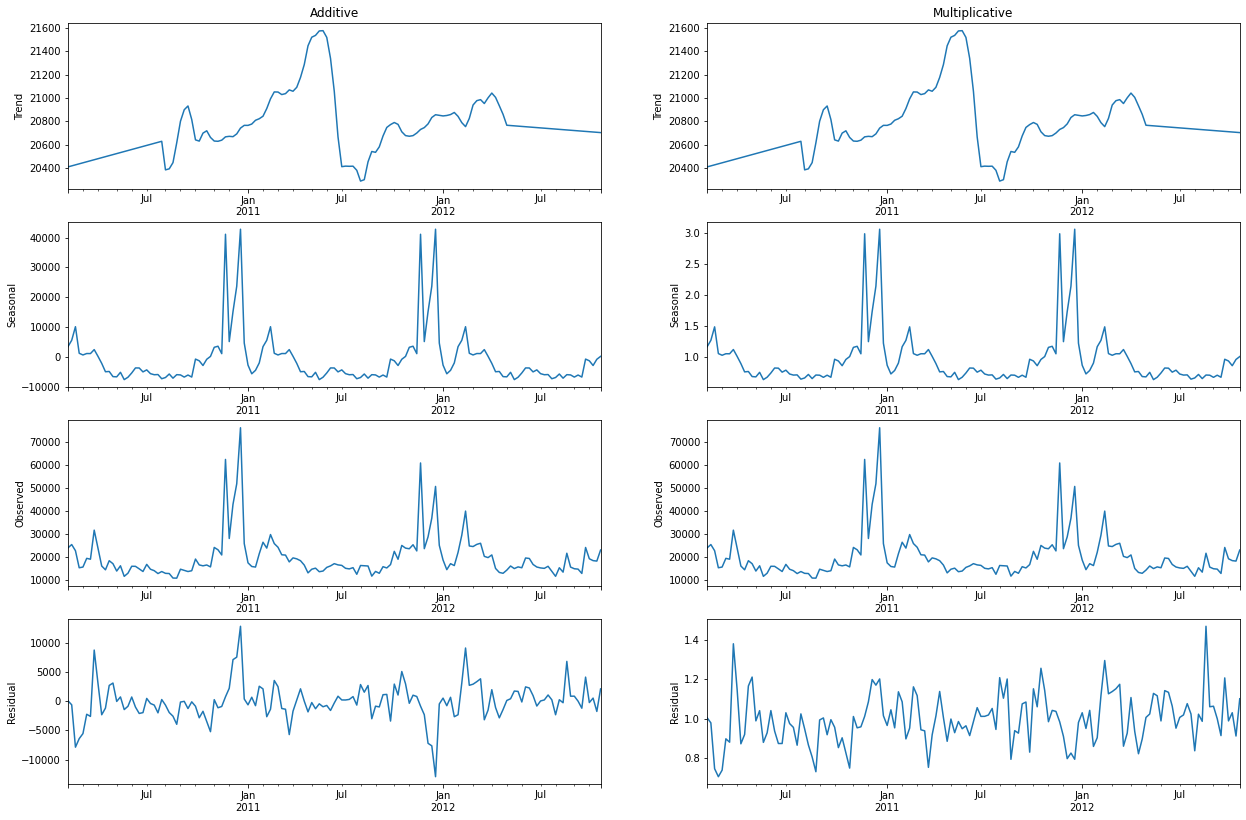

In [13]:
temp = get_decomposition(S8D5_df)

Интервал недельный. Тут очевидно увеличение продаж на Рождество и вероятно некоторые другие праздники. Похоже, что модель аддитивна, стационарна.

In [14]:
forecast_horizon = 4

In [15]:
train = S8D5_df[:-forecast_horizon]
test = S8D5_df[-forecast_horizon:]

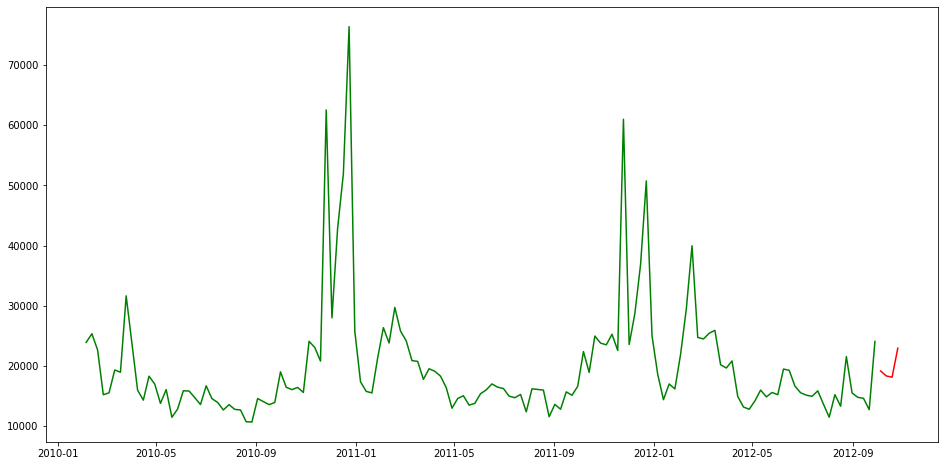

In [16]:
plt.figure(figsize=(16, 8))

plt.plot(train.index, train['sales'], color='g')
plt.plot(test.index, test['sales'], color='r')

In [17]:
naive_preds = predict(S8D5_df, train, forecast_horizon)

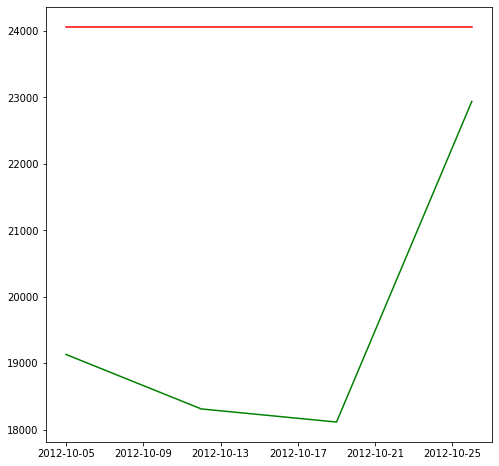

In [18]:
plt.figure(figsize=(8, 8))

plt.plot(test.index, test['sales'], color='g')
plt.plot(naive_preds.index, naive_preds['sales'], color='r')

In [19]:
get_errors(test['sales'], naive_preds['sales'], name='Naive prediction')

,Naive prediction
MAE,4437.74250
RMSE,66.61638
RMSLE,0.22912


In [20]:
average_preds = predict(S8D5_df, train, forecast_horizon, method='average')

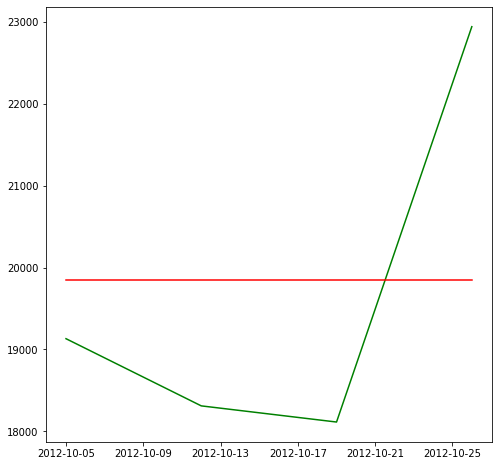

In [21]:
plt.figure(figsize=(8, 8))

plt.plot(test.index, test['sales'], color='g')
plt.plot(average_preds.index, average_preds['sales'], color='r')

In [22]:
get_errors(test['sales'], average_preds['sales'], name='Average prediction')

,Average prediction
MAE,1767.05135
RMSE,42.03631
RMSLE,0.09629


d:\Projects\HillelHW\Hillel_ML_HW\hillel_hw_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
d:\Projects\HillelHW\Hillel_ML_HW\hillel_hw_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
d:\Projects\HillelHW\Hillel_ML_HW\hillel_hw_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\Projects\HillelHW\Hillel_ML_HW\hillel_hw_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-FRI

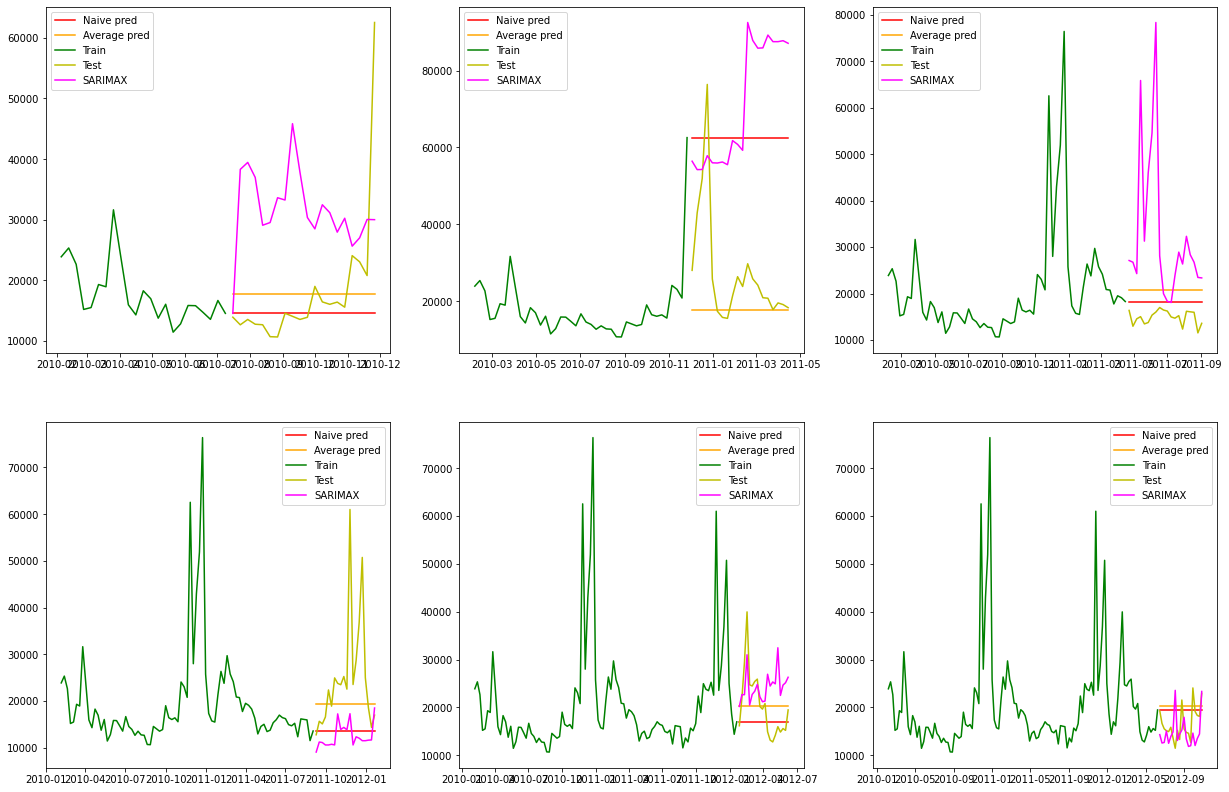

In [136]:
splits = [(x, y) for x, y in TimeSeriesSplit(n_splits=6).split(S8D5_df)]

_, ax = plt.subplots(2, 3, figsize=(21, 14))
axs = ax.flatten()

s_scores = {}

for ax_idx, (train_idxs, test_idxs) in enumerate(splits):
    current_predict = predict(S8D5_df, S8D5_df.iloc[train_idxs], len(test_idxs))
    axs[ax_idx].plot(current_predict.index, current_predict['sales'], color='r')
    
    current_predict = predict(S8D5_df, S8D5_df.iloc[train_idxs], len(test_idxs), method='average')
    axs[ax_idx].plot(current_predict.index, current_predict['sales'], color='orange')
    
    axs[ax_idx].plot(S8D5_df.iloc[train_idxs].index, S8D5_df.iloc[train_idxs]['sales'], color='g')
    axs[ax_idx].plot(S8D5_df.iloc[test_idxs].index, S8D5_df.iloc[test_idxs]['sales'], color='y')
    
    s_model = SARIMAX(S8D5_df.iloc[train_idxs]['sales'], order=(1, 1, 1), seasonal_order=(1,1,1,12)).fit()
    s_predict = s_model.predict(S8D5_df.iloc[test_idxs].index.values[0], S8D5_df.iloc[test_idxs].index.values[-1])
    
    axs[ax_idx].plot(s_predict, color='magenta')
    
    s_scores[ax_idx] = get_errors(S8D5_df.iloc[test_idxs]['sales'], s_predict, 'KFold ' + str(ax_idx))
    
    axs[ax_idx].legend(['Naive pred', 'Average pred', 'Train', 'Test', 'SARIMAX'])
    

In [138]:
s_scores

{0:           KFold 0
 MAE   16997.53828
 RMSE    130.37461
 RMSLE     0.79937,
 1:           KFold 1
 MAE   45767.16798
 RMSE    213.93262
 RMSLE     1.15311,
 2:           KFold 2
 MAE   17703.96339
 RMSE    133.05624
 RMSLE     0.80421,
 3:           KFold 3
 MAE   12488.89898
 RMSE    111.75374
 RMSLE     0.71839,
 4:          KFold 4
 MAE   6521.24567
 RMSE    80.75423
 RMSLE    0.38746,
 5:          KFold 5
 MAE   3594.78435
 RMSE    59.95652
 RMSLE    0.28457}